# Starbucks Capstone Challenge - Predictive and Modelling

## Introduction

Offer Selection

* Remove unsuccessful offers
* Strip the ID and perform a classifier

Receives Offer or Not

* Receives offer if, offer successful and total spent is 20 (10 from promo, + additional product) 

Combination of both will give better results in incremental profit and IRR.

## Setup

In [1]:
import sys

!{sys.executable} -m pip install -e ../ --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sb_capstone.wrangling import (
    clean_transcript_group
)

from sb_capstone.graph import (
    plot_corr    
)

from sb_capstone.shaping import (
    get_transcript_offers,
    convert_for_receive_training,
    convert_for_select_training
)

%matplotlib inline

In [3]:
transcript_group = pd.read_csv("../data/processed/transcript_group.csv")
transcript_group = clean_transcript_group(transcript_group)

transcript_group.head()

,id,wave,diffs,received,viewed,completed,purchased,amount,reward,non_offer_amount,...,mobile,social,gender,age,generation,group,income,membership_year,membership_month,membership_day
0,1,2,48.000000,True,True,False,False,0.00,0.0,0.00,...,True,False,U,NaN,NaN,NaN,NaN,2017,2,12
1,2,2,49.866737,False,False,False,False,0.00,0.0,0.00,...,False,False,F,55.0,boomers,middle_age,112000.0,2017,7,15
2,3,2,36.000000,True,True,False,False,0.00,0.0,0.00,...,True,False,U,NaN,NaN,NaN,NaN,2018,7,12
3,4,2,26.000000,True,True,True,True,19.67,0.0,29.72,...,True,True,F,75.0,silent,old,100000.0,2017,5,9
4,5,2,49.866737,False,False,False,True,0.00,0.0,3.50,...,False,False,U,NaN,NaN,NaN,NaN,2017,8,4


In [4]:
transcript_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102000 entries, 0 to 101999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   id                 102000 non-null  int64   
 1   wave               102000 non-null  int64   
 2   diffs              102000 non-null  float64 
 3   received           102000 non-null  bool    
 4   viewed             102000 non-null  bool    
 5   completed          102000 non-null  bool    
 6   purchased          102000 non-null  bool    
 7   amount             102000 non-null  float64 
 8   reward             102000 non-null  float64 
 9   non_offer_amount   102000 non-null  float64 
 10  mapped_offer       102000 non-null  category
 11  spendings          102000 non-null  float64 
 12  recommended_offer  102000 non-null  int64   
 13  offer_type         102000 non-null  category
 14  difficulty         102000 non-null  float64 
 15  duration           102000 non-null

## Q3. How can we make use of the result to improve the app using machine learning?

Based on our analysis, we found out that giving out these offers randomly can make customers spends more, however, only the discount revenue are the ones providing us revenue. On the other hand, the offers themselves are not good enough to improve customer's response to avail the offer.

Let's look at how we can is to distinguish which demographic are affected by the offers and to those who still spends for the product without the offer.

In [5]:
transcript_group[transcript_group.id == 3]

,id,wave,diffs,received,viewed,completed,purchased,amount,reward,non_offer_amount,...,mobile,social,gender,age,generation,group,income,membership_year,membership_month,membership_day
2,3,2,36.000000,True,True,False,False,0.00,0.0,0.00,...,True,False,U,NaN,NaN,NaN,NaN,2018,7,12
17002,3,3,49.866737,False,False,False,True,0.00,0.0,1.64,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12
34002,3,4,49.866737,False,False,False,True,0.00,0.0,5.09,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12
51002,3,5,49.866737,False,False,False,False,0.00,0.0,0.00,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12
68002,3,6,64.000000,True,False,True,False,2.14,0.0,4.09,...,True,True,U,NaN,NaN,NaN,NaN,2018,7,12
85002,3,1,49.866737,False,False,False,True,0.00,0.0,1.34,...,False,False,U,NaN,NaN,NaN,NaN,2018,7,12


Let's analyze a bit who should be given out with offers.

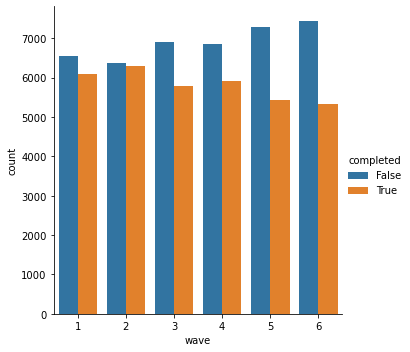

In [6]:
sns.catplot(data=transcript_group[transcript_group.received], kind="count", x="wave", hue="completed");

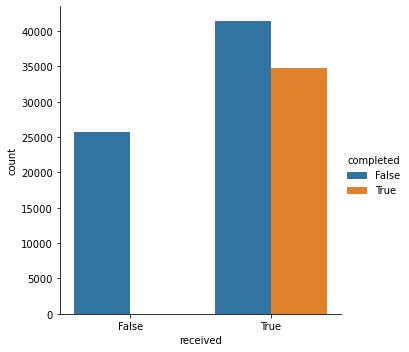

In [7]:
sns.catplot(data=transcript_group, kind="count", x="received", hue="completed");

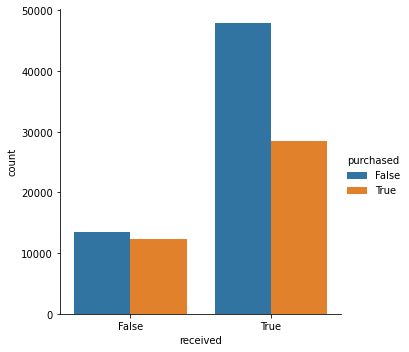

In [8]:
sns.catplot(data=transcript_group, kind="count", x="received", hue="purchased");

### Part 1: Who should be given out with offers?

For the first part, we need things that relates to the customer, as we are going try to check if the customer may respond to the offer. At this point, we are just going to respond based on the demography of the customer.

Also, it'll be useless to add the anonymous customers for our training data, so we are going to remove them as well.

Aside from that, we are also going to limit the data to those who received offer only and how they reacted to it. This way we'll now if it's effective or not.

In [9]:
data = convert_for_receive_training(transcript_group.copy())
data.head()

,purchased,gender,age,income,membership_year,membership_month,membership_day,gen_z,millenials,gen_x,boomers,silent,young,adult,middle_age,old
3,1,0.0,75.0,100000.0,2017,5,9,0,0,0,0,1,0,0,0,1
8,1,1.0,65.0,53000.0,2018,2,9,0,0,0,1,0,0,0,0,1
12,0,1.0,58.0,51000.0,2017,11,11,0,0,0,1,0,0,0,1,0
13,1,0.0,61.0,57000.0,2017,9,11,0,0,0,1,0,0,0,0,1
14,0,1.0,26.0,46000.0,2014,2,13,0,1,0,0,0,0,1,0,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 3 to 101999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   purchased         66501 non-null  int32  
 1   gender            65585 non-null  float64
 2   age               66501 non-null  float64
 3   income            66501 non-null  float64
 4   membership_year   66501 non-null  int64  
 5   membership_month  66501 non-null  int64  
 6   membership_day    66501 non-null  int64  
 7   gen_z             66501 non-null  uint8  
 8   millenials        66501 non-null  uint8  
 9   gen_x             66501 non-null  uint8  
 10  boomers           66501 non-null  uint8  
 11  silent            66501 non-null  uint8  
 12  young             66501 non-null  uint8  
 13  adult             66501 non-null  uint8  
 14  middle_age        66501 non-null  uint8  
 15  old               66501 non-null  uint8  
dtypes: float64(3), int32(1), int64(3), uint

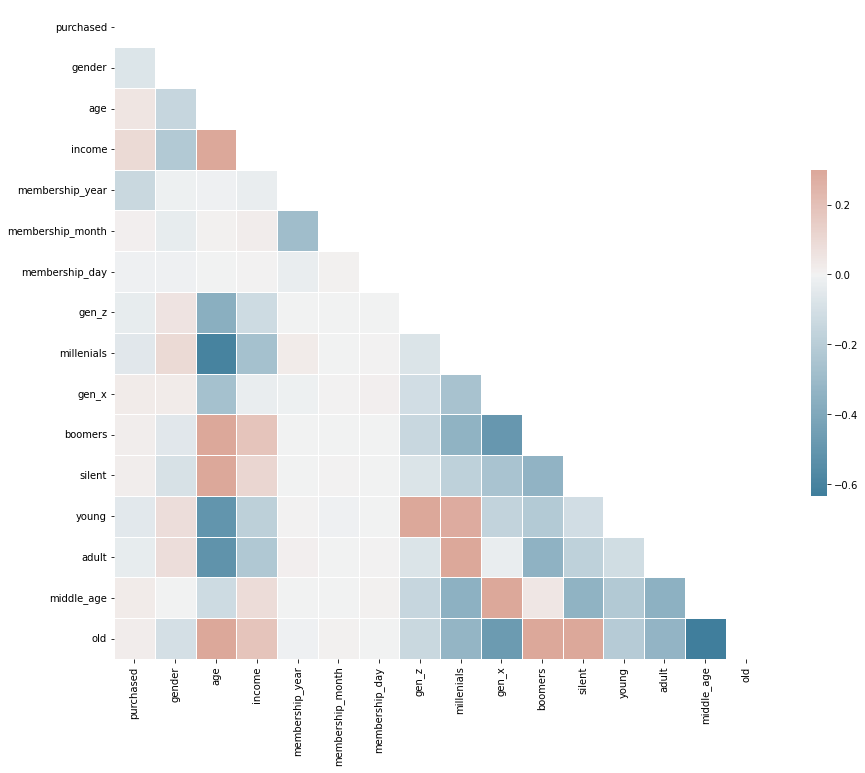

In [11]:
plot_corr(data.corr())

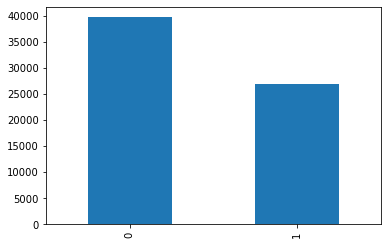

In [12]:
data.purchased.value_counts().plot(kind="bar");

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(initial_strategy="most_frequent")
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

In [14]:
data.head()

,purchased,gender,age,income,membership_year,membership_month,membership_day,gen_z,millenials,gen_x,boomers,silent,young,adult,middle_age,old
0,1.0,0.0,75.0,100000.0,2017.0,5.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,1.0,65.0,53000.0,2018.0,2.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,58.0,51000.0,2017.0,11.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,61.0,57000.0,2017.0,9.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,26.0,46000.0,2014.0,2.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   purchased         66501 non-null  float64
 1   gender            66501 non-null  float64
 2   age               66501 non-null  float64
 3   income            66501 non-null  float64
 4   membership_year   66501 non-null  float64
 5   membership_month  66501 non-null  float64
 6   membership_day    66501 non-null  float64
 7   gen_z             66501 non-null  float64
 8   millenials        66501 non-null  float64
 9   gen_x             66501 non-null  float64
 10  boomers           66501 non-null  float64
 11  silent            66501 non-null  float64
 12  young             66501 non-null  float64
 13  adult             66501 non-null  float64
 14  middle_age        66501 non-null  float64
 15  old               66501 non-null  float64
dtypes: float64(16)
memory usage: 8.1 MB


We are going to use a simple logistic regression for this one using `purchased` as response variable.

In [16]:
from sklearn.model_selection import train_test_split

y = data.purchased
X = data.drop(columns=["purchased"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [18]:
from sklearn.metrics import classification_report

y_true = lr.predict(X_test)

print(classification_report(y_true, y_test))

              precision    recall  f1-score   support

         0.0       0.97      0.59      0.73     16039
         1.0       0.04      0.44      0.07       587

    accuracy                           0.59     16626
   macro avg       0.50      0.52      0.40     16626
weighted avg       0.93      0.59      0.71     16626



Let's feed this to `GridSearchCV`.

In [19]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("clf", LogisticRegression())
])

After trial and error, I selected the top 3 algorithms that yield best results. For this instance, we'll make use of F1-score as this a balance between precision and recall.

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

parameters_clf = {
    "clf": [
        LogisticRegression(),
        DecisionTreeClassifier(),
        KNeighborsClassifier()
    ]
}

In [21]:
from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(pipeline, parameters_clf, verbose=1)
cv.fit(X_train, y_train)
print(cv.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'clf': DecisionTreeClassifier()}


In [22]:
y_true = cv.predict(X_test)

print(classification_report(y_true, y_test))

              precision    recall  f1-score   support

         0.0       0.78      0.65      0.71     11612
         1.0       0.41      0.56      0.48      5014

    accuracy                           0.63     16626
   macro avg       0.59      0.61      0.59     16626
weighted avg       0.67      0.63      0.64     16626



F1 score on average at 0.63, proactively giving out offers 5011 out of 11615, should be good enough to setup the next experiment.

Let's export this later for library use.

In [23]:
joblib.dump(cv, "../models/receive_offer.pkl")

['../models/receive_offer.pkl']

### Part 2: Which offer should we give out?

Examining the current data that we have, this can be answered by creating a recommendation system for the customer. However, we are going to make use of the customer features and try to classify which offer fits best. On this instance, we are going to create a multi-output classifier.

We need to perform the following first.
* We need to flatten further the dataset and get the successful offers

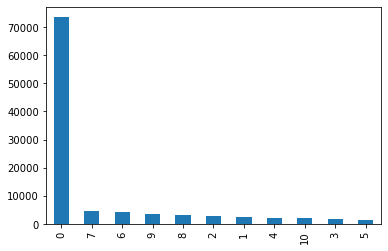

In [24]:
transcript_group.recommended_offer.value_counts().plot(kind="bar");

Those successful and did not received any offer have way more samples. Since we already have a model to select who will receive and not, we can remove those later.

In [25]:
data = get_transcript_offers(transcript_group)

data.head()

,id,recommended_offer,gender,age,income,membership_year,membership_month,membership_day
0,1,"[7, 6]",U,NaN,NaN,2017,2,12
1,4,"[8, 1, 4]",F,75.0,100000.0,2017,5,9
2,6,"[4, 7]",M,68.0,70000.0,2018,4,26
3,9,"[4, 10, 9, 7]",M,65.0,53000.0,2018,2,9
4,11,[1],U,NaN,NaN,2017,8,24


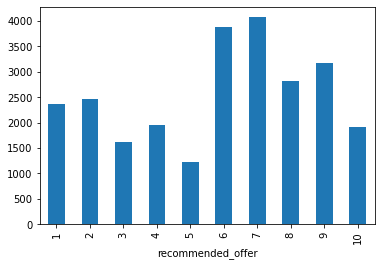

In [26]:
data.explode("recommended_offer").groupby("recommended_offer").id.count().plot(kind="bar");

After extracting the offers, even though we have sort of imbalance in the distribution, it's not that much, we'll try to train this for now.

Let's prepare the data for training.

In [27]:
data = convert_for_select_training(transcript_group)
print(len(data))
data.head()

11587


,gender,age,income,membership_year,membership_month,membership_day,1,2,3,4,5,6,7,8,9,10
0,0,75.0,100000.0,2017,5,9,1,0,0,1,0,0,0,1,0,0
1,1,68.0,70000.0,2018,4,26,0,0,0,1,0,0,1,0,0,0
2,1,65.0,53000.0,2018,2,9,0,0,0,1,0,0,1,0,1,1
3,1,58.0,51000.0,2017,11,11,0,0,0,0,0,0,1,0,0,0
4,0,61.0,57000.0,2017,9,11,0,1,0,0,0,0,0,0,1,0


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11587 entries, 0 to 11586
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            11587 non-null  int64  
 1   age               11587 non-null  float64
 2   income            11587 non-null  float64
 3   membership_year   11587 non-null  int64  
 4   membership_month  11587 non-null  int64  
 5   membership_day    11587 non-null  int64  
 6   1                 11587 non-null  uint8  
 7   2                 11587 non-null  uint8  
 8   3                 11587 non-null  uint8  
 9   4                 11587 non-null  uint8  
 10  5                 11587 non-null  uint8  
 11  6                 11587 non-null  uint8  
 12  7                 11587 non-null  uint8  
 13  8                 11587 non-null  uint8  
 14  9                 11587 non-null  uint8  
 15  10                11587 non-null  uint8  
dtypes: float64(2), int64(4), uint8(10)
memor

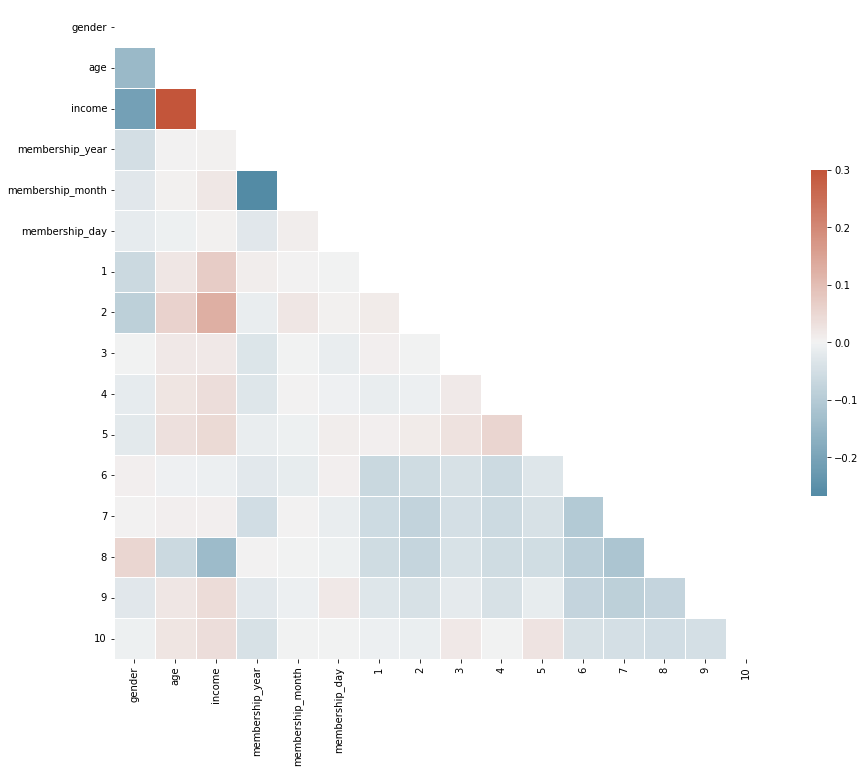

In [29]:
plot_corr(data.corr())

In [30]:
y_cols = np.arange(1, 11).astype(str).tolist()

y = data[y_cols]
X = data[data.columns[~data.columns.isin(y_cols)]]

X_train, X_test, y_train, y_test = train_test_split(X, y)

len(X_train), len(X_test)

(8690, 2897)

Let's make use of `MultiOutputClassifier` and `KNeighborsClassifier`.

In [31]:
from sklearn.multioutput import MultiOutputClassifier

clf = MultiOutputClassifier(KNeighborsClassifier())
clf.fit(X, y)

MultiOutputClassifier(estimator=KNeighborsClassifier())

In [32]:
y_pred = clf.predict(X_test)

print(classification_report(y_pred, y_test, zero_division=1))

              precision    recall  f1-score   support

           0       0.18      0.65      0.28       164
           1       0.21      0.61      0.31       210
           2       0.07      0.63      0.13        41
           3       0.11      0.59      0.19        81
           4       0.08      0.56      0.14        43
           5       0.34      0.64      0.44       453
           6       0.38      0.65      0.48       535
           7       0.24      0.68      0.36       228
           8       0.29      0.63      0.39       331
           9       0.14      0.67      0.23        91

   micro avg       0.24      0.64      0.35      2177
   macro avg       0.20      0.63      0.30      2177
weighted avg       0.28      0.64      0.38      2177
 samples avg       0.24      0.79      0.28      2177



In [33]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC

pipeline = Pipeline([
    ("clf", MultiOutputClassifier(estimator=KNeighborsClassifier()))
])

parameters_clf = {
    "clf__estimator": [
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        ExtraTreeClassifier()
    ]
}

cv = GridSearchCV(pipeline, parameters_clf, verbose=1)
cv.fit(X_train, y_train)

print(cv.best_params_)
print(cv.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'clf__estimator': KNeighborsClassifier()}
0.028883774453394705


In [34]:
parameters_kn = {
    "clf__estimator__n_neighbors": [1, 3, 5],
    "clf__estimator__algorithm": ["ball_tree", "kd_tree"],
    "clf__estimator__p": [1, 2],
    "clf__estimator__leaf_size": [10, 30]
}

cv = GridSearchCV(pipeline, parameters_kn, verbose=1)
cv.fit(X_train, y_train)

print(cv.best_params_)
print(cv.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'clf__estimator__algorithm': 'kd_tree', 'clf__estimator__leaf_size': 10, 'clf__estimator__n_neighbors': 5, 'clf__estimator__p': 1}
0.029459148446490217


In [35]:
y_pred = cv.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.24      0.07      0.11       588
           1       0.28      0.08      0.13       618
           2       0.10      0.01      0.02       353
           3       0.14      0.03      0.05       423
           4       0.08      0.01      0.02       293
           5       0.27      0.19      0.22       860
           6       0.32      0.20      0.24       907
           7       0.24      0.09      0.14       632
           8       0.24      0.11      0.15       729
           9       0.21      0.04      0.07       443

   micro avg       0.26      0.10      0.15      5846
   macro avg       0.21      0.08      0.12      5846
weighted avg       0.24      0.10      0.14      5846
 samples avg       0.53      0.11      0.12      5846



The model is not performing well, but it's a good start for a targeted experiment. We'll save the model for use later.

In [36]:
joblib.dump(cv, "../models/select_offer.pkl")

['../models/select_offer.pkl']

## Next Steps

The first experiments we did was done randomly and not targeted. Also, the demographical data is very limited, therefore, we can't go so much as we optimize our models.

However, even our models are not performing well, we can perform a better experiment by performing the following steps.

1. Use our model to determine if we are going to offer the user an offer or not.
2. If we are going to provide an offer, use the other model to select which model to offer. Since, we do return multiple offers, we can scatter them into different waves for variety.

In our next notebook, we are going to implement these.